In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.pardir))

# Thêm đường dẫn gốc vào sys.path nếu chưa có
if project_root not in sys.path:
    sys.path.append(project_root)

# Kiểm tra xem đã nhận chưa
print(f"Project Root: {project_root}")

Project Root: d:\University\HK7\IT_Project\Project\Source


In [3]:
from utils.config import PathConfig
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

# Tải dữ liệu trên Hugging Face

In [8]:
def load_image_paths(image_dir, label_code: int):
    image_paths = []
    labels = []
    
    # Load image
    with os.scandir(image_dir) as entries:
        valid_entries = [entry for entry in entries if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for entry in tqdm(valid_entries, desc=f"Xử lý {os.path.basename(image_dir)}"):
            try:
                Image.open(entry.path).verify() 
                image_paths.append(entry.path)
                labels.append(label_code)
            except:
                print(f"Ảnh lỗi: {entry.path}, bỏ qua.")
                
    return image_paths, labels


def collect_data_paths(real_dir='data/Real', ai_dir='data/AI_Generated'):
    paths = []
    labels = []  # 0: Real, 1: AI_Generated
    
    # Load Real
    real_paths, real_labels = load_image_paths(real_dir, 0)
    paths.extend(real_paths)
    labels.extend(real_labels)

    # Load AI_Generated
    ai_paths, ai_labels = load_image_paths(ai_dir, 1)
    paths.extend(ai_paths)
    labels.extend(ai_labels)
    
    print(f"Tổng số ảnh hợp lệ: {len(paths)} (Real: {labels.count(0)}, AI: {labels.count(1)})")
    return paths, labels

image_paths, image_labels = collect_data_paths(PathConfig.REAL_IMGS, PathConfig.AI_GEN_IMGS)

Xử lý AI_Generated: 100%|██████████| 9809/9809 [00:12<00:00, 773.36it/s] 

Tổng số ảnh hợp lệ: 19809 (Real: 10000, AI: 9809)


In [9]:
def split_and_save_data(paths, labels, output_dir='split_data', test_size=0.2, val_size=0.1, random_state=42):
    # Tạo thư mục output nếu chưa có
    os.makedirs(output_dir, exist_ok=True)
    
    # Chia train/test
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, test_size=test_size, stratify=labels, random_state=random_state
    )
    
    # Chia val từ train
    val_ratio = val_size / (1 - test_size)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=val_ratio, stratify=train_labels, random_state=random_state
    )
    
    # Lưu vào CSV: Mỗi file có cột 'path' và 'label'
    def save_to_csv(paths_list, labels_list, file_name):
        df = pd.DataFrame({'path': paths_list, 'label': labels_list})
        df.to_csv(os.path.join(output_dir, file_name), index=False)
        print(f"Đã lưu {file_name} với {len(paths_list)} mẫu")
    
    save_to_csv(train_paths, train_labels, 'train.csv')
    save_to_csv(val_paths, val_labels, 'val.csv')
    save_to_csv(test_paths, test_labels, 'test.csv')


# Chia và lưu dữ liệu
split_and_save_data(image_paths, image_labels, output_dir=PathConfig.SPILTTED_DATASETS)

Đã lưu train.csv với 13866 mẫu
Đã lưu val.csv với 1981 mẫu
Đã lưu test.csv với 3962 mẫu


In [10]:
def load_split_data(output_dir: str):
    train_df = pd.read_csv(os.path.join(output_dir, 'train.csv'))
    val_df = pd.read_csv(os.path.join(output_dir, 'val.csv'))
    test_df = pd.read_csv(os.path.join(output_dir, 'test.csv'))
    return train_df, val_df, test_df


train_data, val_data, test_data = load_split_data(PathConfig.SPILTTED_DATASETS)
print(f"Tập Train: {len(train_data)}, Tập Val: {len(val_data)}, Tập Test: {len(test_data)}")

Tập Train: 13866, Tập Val: 1981, Tập Test: 3962


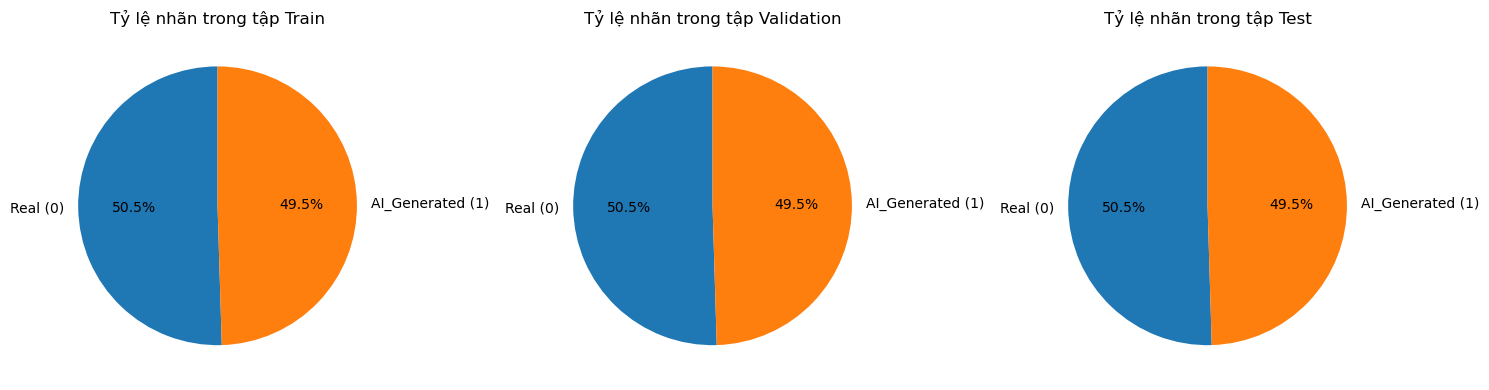

In [11]:
def visualize_label_ratios(df_list: list[pd.DataFrame], titles: list[str]):
    # Tạo figure với 3 subplot
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))

    for i in range(3):
        # Đếm tỷ lệ nhãn (normalize để lấy phần trăm)
        label_counts = df_list[i]['label'].value_counts(normalize=True) * 100
        
        # Vẽ pie chart
        axs[i].pie(label_counts, labels=['Real (0)', 'AI_Generated (1)'], autopct='%1.1f%%', startangle=90)
        axs[i].set_title(titles[i])

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()


list_of_dfs = [train_data, val_data, test_data]
titles = ['Tỷ lệ nhãn trong tập Train', 'Tỷ lệ nhãn trong tập Validation', 'Tỷ lệ nhãn trong tập Test']
visualize_label_ratios(list_of_dfs, titles)